## 1. 라이브러리 가져오기
## Import Library

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import os
from pathlib import Path

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [2]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [3]:
# 날짜 처리
data = pd.read_csv('../../201901-202003.csv')
# data = pd.read_csv('data/201901-202003.csv')
# data = pd.read_csv(os.path.join(Path(self).resolve().parent, '201901-202003.csv')) 
data = data.fillna('')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

In [4]:
# data.head(5)

In [5]:
# data.tail(5)

In [5]:
# 데이터 정제 + 컬럼 추가

'''
# 추가해볼 만한 컬럼
# 거주 지역과 결제 지역이 같으면 1, 다르면 0
# CNT를 min max로 나눠서 10개 카테고리로 나눠서 해보기
# 업종에 나이가 영향을 줄 수 있지 않을까
# feature 상관분석, PCA 해보기
'''

df = data.copy()

# 1. 계절 / 봄(1), 여름(2), 가을(3), 겨울(4)
df.loc[(df['month']>=3)&(df['month']<=5) ,'season'] = 1
df.loc[(df['month']>=6)&(df['month']<=8) ,'season'] = 2
df.loc[(df['month']>=9)&(df['month']<=11) ,'season'] = 3
df.loc[(df['month']>11),'season'] = 4
df.loc[(df['month']<=2),'season'] = 4

# df

# 2. 거주(1) or 여행(0)
df.loc[(df['CARD_SIDO_NM'] == df['HOM_SIDO_NM']), 'visitor'] = 1
df.loc[(df['CARD_SIDO_NM'] != df['HOM_SIDO_NM']), 'visitor'] = 0

# df

# 3. 결제 건수 20개 범위로 나누기 
df['CNT_Category'] = pd.cut(df['CNT'], 10, labels=False)

# df

# CNT 처리하기 위해 정리한 것
# cut은 범위를 동일하게 자른 것, qcut은 범위 내에 들어오는 갯수가 동일하게 자른 것

# print(max(df['CNT']))
# print(min(df['CNT']))

# df['CNT']

# pd.cut(df['CNT'], 20, labels=False)

# cnt_category = pd.qcut(df['CNT'], 20, labels=False)
# print(cnt_category)
# print(cnt_category[0])
# print(cnt_category[1])
# print(cnt_category[1057391])

# cnt_category = pd.cut(df['CNT'], 20, labels=False)
# print(max(cnt_category)) # 19
# print(min(cnt_category)) # 0
# print(len(df['CNT']))
# print(cnt_category)

# 4. 코로나
#covid = ['관광 민예품 및 선물용품 소매업','그외 기타 분류안된 오락관련 서비스업','그외 기타 스포츠시설 운영업','기타 대형 종합 소매업','기타 수상오락 서비스업','기타 외국식 음식점업','기타 주점업','내항 여객 운송업','마사지업','면세점','버스 운송업','비알콜 음료점업','서양식 음식점업','스포츠 및 레크레이션 용품 임대업','여관업','여행사업','욕탕업','일반유흥 주점업','일식 음식점업','자동차 임대업','전시 및 행사 대행업','정기 항공 운송업','중식 음식점업','차량용 가스 충전업','차량용 주유소 운영업','체인화 편의점','택시 운송업','피자 햄버거 샌드위치 및 유사 음식점업','한식 음식점업','호텔업','화장품 및 방향제 소매업','휴양콘도 운영업']
#df['covid'] = False
#for virus in covid:
#    df.loc[(df['STD_CLSS_NM'] == virus),'covid'] = True

# df

In [6]:
# 0. 컬럼 드랍
#df = data.copy()

df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM', 'CNT_Category', 'covid'], axis=1)

# 0. 독립 변수 선정
# columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'season', 'visitor', 'CNT_Category', 'covid']
# 위에 총 12개 독립변수로 모델을 학습시켜본 뒤, 가장 영향 없는 4가지 삭제
# temp 생성하는 부분에 부하를 줄이기 위해 4개(covid, SEX_CTGO_CD, visitor, FLC) 없이 진행
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'season', 'visitor']

df = df.groupby(columns).sum().reset_index(drop=False)

In [7]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

## 3. 탐색적 자료분석
## Exploratory Data Analysis

In [12]:
# # 시도 컬럼 수

# print(len(data.CARD_SIDO_NM))

# sido = pd.Series.unique(data.CARD_SIDO_NM)
# print(len(sido))
# print(sido)

# # 시군구 컬럼 수

# print(len(data.CARD_CCG_NM))

# ccg = pd.Series.unique(data.CARD_CCG_NM)
# print(len(ccg))
# print(ccg)

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [8]:
# feature, target 설정
train_num = df_num.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [9]:
k = int(len(train_features)*0.9)

x_train = train_features[:k]
y_train = train_target[:k]
x_val = train_features[k:]
y_val = train_target[k:]

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [10]:
import lightgbm as lgbm

In [11]:
train_ds = lgbm.Dataset(x_train, label=y_train)
val_ds = lgbm.Dataset(x_val, label=y_val)

In [12]:
# 파라미터 종류 참고 : https://lightgbm.readthedocs.io/en/latest/Parameters.html
# 파라미터 튜닝 참고 : https://greatjoy.tistory.com/72

params = {
            'learning_rate' : 0.01, # 일반적으로 0.01 ~ 0.1, 성능 높일 때 값 줄여서 진행
            #'num_iterations' : 1000, # 디폴트는 100 / 너무 크게하면 과적합 발생 위험
            # 'max_depth' : -1, # 디폴트는 -1 / 0 이하는 제한 없다는 뜻, featureure가 많으면 depth를 크게 가져가야 함
            'boosting': 'gbdt', # 디포트는 gbdt / rf(RandomForest), dart(정확도 중요할 때 사용), goss(샘플링 이용)  / boosting, boosting_type, boost 다 같은 말
            'objective': 'tweedie', # 디폴트는 regression / regression 종류 : regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
#             'objective': 'multiclass', # 멀티 클래스로 지정
#             'num_class': 41, # 클래스 수는 업종 수인 41개로 지정
            'tweedie_variance_power': 1.1,
#             'metric': 'softmax',
            'metric': 'custom',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1 # 정규화로 과적합 방지 / 정확도 저하될 수 있기 떄문에 일반적으로는 default 0 그대로 유지
        }

In [13]:
def rmsle_1(y_pred, data):
    y_true = np.array(data.get_label())
    score= np.sqrt(np.square(np.log1p(y_pred + 1) - np.log1p(y_true + 1)).mean())
    return 'rmsle', score, False

In [14]:
# 훈련
model = lgbm.train(params,
                   train_ds,
                   20000,
                   val_ds,
                   verbose_eval = 1000,
                   early_stopping_rounds = 1000,
                   feval = rmsle_1
                 )

Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's rmsle: 0.0924875
[2000]	valid_0's rmsle: 0.0818452
[3000]	valid_0's rmsle: 0.0763053
[4000]	valid_0's rmsle: 0.0724267
[5000]	valid_0's rmsle: 0.0694374
[6000]	valid_0's rmsle: 0.067166
[7000]	valid_0's rmsle: 0.0653641
[8000]	valid_0's rmsle: 0.0638211
[9000]	valid_0's rmsle: 0.0624594
[10000]	valid_0's rmsle: 0.0613502
[11000]	valid_0's rmsle: 0.0604273
[12000]	valid_0's rmsle: 0.0593962
[13000]	valid_0's rmsle: 0.0585191
[14000]	valid_0's rmsle: 0.057753
[15000]	valid_0's rmsle: 0.0571002
[16000]	valid_0's rmsle: 0.0565062
[17000]	valid_0's rmsle: 0.0559619
[18000]	valid_0's rmsle: 0.0554812
[19000]	valid_0's rmsle: 0.0549281
[20000]	valid_0's rmsle: 0.0544707
Did not meet early stopping. Best iteration is:
[20000]	valid_0's rmsle: 0.0544707


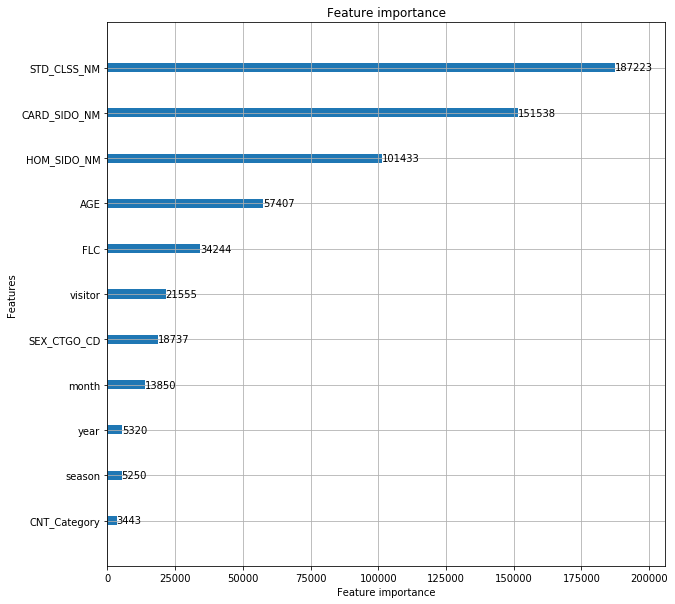

In [15]:
# Feature 비중 확인 feat. KMH

# feature_names =  ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'season', 'visitor', 'CNT_Category', 'covid']
# 먼저 12개의 독립변수의 비중을 확인해본 후, 낮은 변수들은 삭제

# index = np.arange(len(feature_names))

import matplotlib.pyplot as plt
from lightgbm import plot_importance
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 10))
plot_importance(model, max_num_features=12, ax=ax)

In [ ]:
''' 
# 참고 : https://injo.tistory.com/48
# 참고 : https://www.kaggle.com/ashishpatel26/feature-importance-of-lightgbm
# 참고 : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

feature_names = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
index = np.arange(len(feature_names))

import matplotlib.pyplot as plt

plt.barh(index, model.feature_importances_, align='center')
plt.yticks(index, feature_names)
plt.ylim(-1, len(feature_names))
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()
'''

In [34]:
# # Model Save
# from sklearn.externals import joblib
# joblib.dump(model, 'lgbm_gbdt_tweedie_1000epochs.pkl')

# # Model Load
# load_model = joblib.load('lgbm_dart_multiclass(41)_1000epochs.pkl')

## 6. 결과 및 결언
## Conclusion & Discussion

In [17]:
# 예측 템플릿 만들기

CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()

seasons       = df_num['season'].unique()
visitors      = df_num['visitor'].unique()
#CNT_Categories= df_num['CNT_Category'].unique()
#covids        = df_num['covid'].unique()

years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for season in seasons:
                            for visitor in visitors:
                                #for CNT_Category in CNT_Categories:
                                    #for covid in covids:
                                        for year in years:
                                            for month in months:
                                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC,
                                                             season, visitor, #CNT_Category, covid,
                                                             year, month])

# =====> 아래처럼 수정 

# from itertools import product

# items = [list(CARD_SIDO_NMs), list(STD_CLSS_NMs), list(HOM_SIDO_NMs), list(AGEs), list(SEX_CTGO_CDs), list(FLCs),
#          list(seasons), list(visitors), # list(CNT_Categories), list(covids),
#          years, months]

# temp = list(product(*items))

# ----------------------------

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

ValueError: Shape of passed values is (13270880, 9), indices imply (13270880, 11)

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
# 제출 파일 만들기
submission = pd.read_csv('data/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('HDLY_0717.csv', encoding='utf-8-sig')
submission.head()